In [1]:
# 1. Imports and Setups

In [2]:
import pandas as pd
import nltk
import re
import numpy as np
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import figure
from collections import Counter, defaultdict

import torch
import transformers

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,precision_score,accuracy_score,f1_score

from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments, DistilBertTokenizerFast,DistilBertForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/suchirmvelpanur/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/suchirmvelpanur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/suchirmvelpanur/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/suchirmvelpanur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
# Check for GPU availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
# 2. Loading dataset from URL https://www.kaggle.com/datasets/ankurzing/sentiment-analysis-for-financial-news
df = pd.read_csv('financial_data.csv', encoding="cp1252")
df

,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,neutral,Technopolis plans to develop in stages an area...
1,negative,The international electronic industry company ...
2,positive,With the new production plant the company woul...
3,positive,According to the company 's updated strategy f...
4,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
...,...,...
4840,negative,LONDON MarketWatch -- Share prices ended lower...
4841,neutral,Rinkuskiai 's beer sales fell by 6.5 per cent ...
4842,negative,Operating profit fell to EUR 35.4 mn from EUR ...
4843,negative,Net sales of the Paper segment decreased to EU...


In [5]:
# 3. Preprocessing the dataset 

In [6]:
# Checking shape of scraped dataset
df.shape

(4845, 2)

In [7]:
# 3.1 Setting column names as dataset has no named columns
df.columns = ['Sentiment', 'Text']

In [8]:
# 3.2 Checking for null values in the dataset
df.isna().sum()

Sentiment    0
Text         0
dtype: int64

In [9]:
# 3.3 Checking for duplicates
df.duplicated().sum()

6

In [10]:
duplicate_rows = df[df.duplicated()]
duplicate_rows # => no true duplicates

,Sentiment,Text
1098,neutral,The issuer is solely responsible for the conte...
1415,neutral,The report profiles 614 companies including ma...
2395,neutral,Ahlstrom 's share is quoted on the NASDAQ OMX ...
2566,neutral,SSH Communications Security Corporation is hea...
3093,neutral,Proha Plc ( Euronext :7327 ) announced today (...
3205,neutral,The company serves customers in various indust...


In [11]:
# 3.4 Checking for data distribution of labels in the dataset
df.Sentiment.value_counts()/df.shape[0]

Sentiment
neutral     0.594014
positive    0.281321
negative    0.124665
Name: count, dtype: float64

In [12]:
'''
3.5 Clean the data relevant to NLP task
- Remove punctuations 
- Remove stop word (articles, prepositions, etc.)
- Normalize the text data (by applying a Stemmer or a Lemmatizer).
- Set all characters to lowercase.
- Remove numbers (or convert numbers to  textual representations).
'''

'\n3.5 Clean the data relevant to NLP task\n- Remove punctuations \n- Remove stop word (articles, prepositions, etc.)\n- Normalize the text data (by applying a Stemmer or a Lemmatizer).\n- Set all characters to lowercase.\n- Remove numbers (or convert numbers to  textual representations).\n'

In [13]:
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

def cleaning_data(text):
  text = str(text).lower()
  text = text.replace('{html}', "")
  cleanr = re.compile('<.*?>')
  cleantext = re.sub(cleanr, '', text)
  rem_url = re.sub(r'http\S+', '',cleantext)
  rem_num = re.sub('[0-9]+', '', rem_url)
  tokenizer = RegexpTokenizer(r'\w+')
  tokens = tokenizer.tokenize(rem_num)  
  filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]
  stem_words = [stemmer.stem(w) for w in filtered_words]
  lemma_words = [lemmatizer.lemmatize(w) for w in stem_words]
  return " ".join(filtered_words)
df['Text'] = df['Text'].map(lambda s:cleaning_data(s)) 

In [14]:
# 3.6 Using wordcloud library to visualise textual data patterns

Word Cloud for Neutral Sentiment :


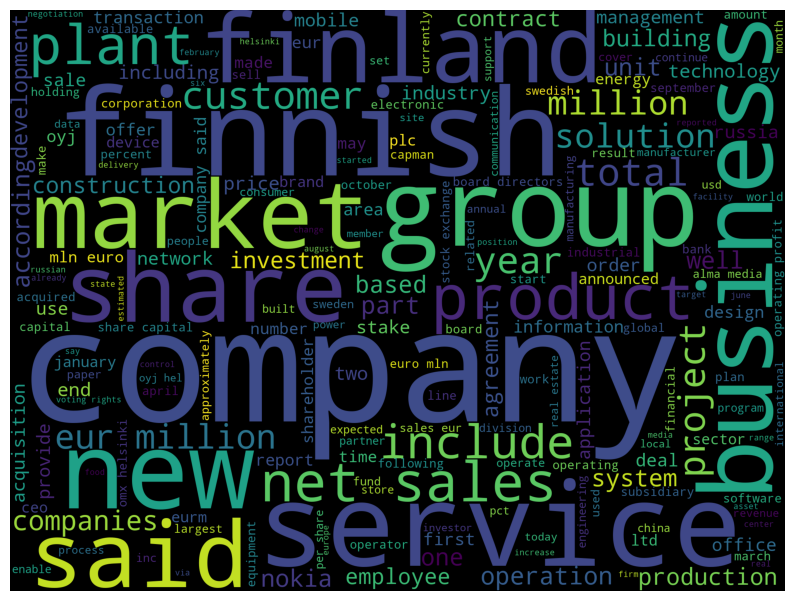

In [15]:
def plot_wordcloud(data):
  words = ' '.join(data['Text'])
  no_urls_no_tags = " ".join([word for word in words.split()])

  wordcloud = WordCloud(stopwords = STOPWORDS,
                        background_color = 'black',
                        width = 2000,
                        height = 1500
                      ).generate(no_urls_no_tags)

  plt.figure(1,figsize = (10, 10))
  plt.imshow(wordcloud)
  plt.axis('off')
  plt.show()

print('Word Cloud for Neutral Sentiment :')
plot_wordcloud(df[df['Sentiment']=='neutral']) #say

Word Cloud for Negative Sentiment :


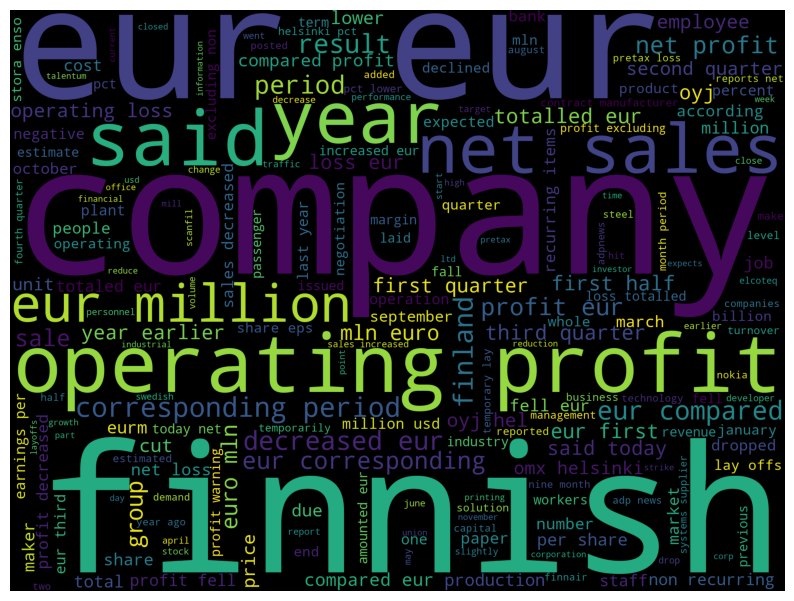

In [16]:
print('Word Cloud for Negative Sentiment :')
plot_wordcloud(df[df['Sentiment']=='negative'])

Word Cloud for Positive Sentiment :


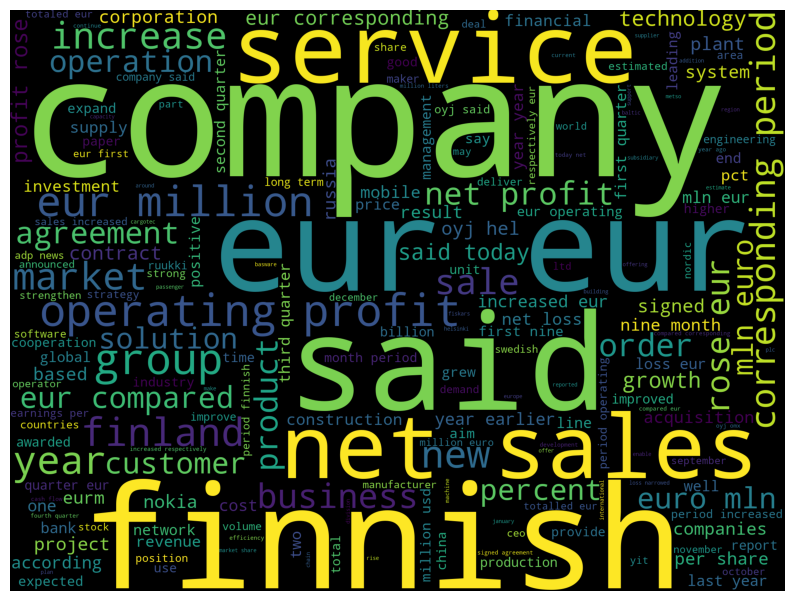

In [17]:
print('Word Cloud for Positive Sentiment :')
plot_wordcloud(df[df['Sentiment']=='positive'])

In [18]:
# 3.7 Using n-grams to compute word frequencies

def ngrams(input, n):
    """ INPUT : Sentence and number of n-grams
  OUTPUT : N-Grams
  * An n-gram is a contiguous sequence of n items from a given sample of text or speech.
  """
    output = []
    for i in range(len(input)-n+1):
        output.append('_'.join(input[i:i+n]))
    return output

nltk.download('punkt')
tags = ['neutral','negative','positive'] 
df = df[df.Sentiment.isin(tags)]

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/suchirmvelpanur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
# 3.8 Create N-Grams
df['Tokens'] = df.apply(lambda row: nltk.word_tokenize(row['Text'].strip()), axis=1)
df['Bi_grams']  = df.apply(lambda row: ngrams(row['Tokens'], 2), axis=1)
df['Tri_grams']  = df.apply(lambda row: ngrams(row['Tokens'], 3), axis=1)
print(len(df),'Samples from',len(tags),'classes')

4845 Samples from 3 classes


In [20]:
# 3.9 Find frequency of say first 25 words
c_unique = Counter()
for ind in df.index:
    c_unique.update(Counter(set(df.loc[ind]['Tokens'])))

print('First 25 common words:\n')
for word in c_unique.most_common(25):
    print(word[0],'-->', 'appeared in',word[1],'documents out of {} documents i.e.'.format(len(df)),np.round(100*word[1]/len(df),2),'%')

First 25 common words:

eur --> appeared in 801 documents out of 4845 documents i.e. 16.53 %
company --> appeared in 800 documents out of 4845 documents i.e. 16.51 %
said --> appeared in 544 documents out of 4845 documents i.e. 11.23 %
finnish --> appeared in 512 documents out of 4845 documents i.e. 10.57 %
sales --> appeared in 428 documents out of 4845 documents i.e. 8.83 %
profit --> appeared in 406 documents out of 4845 documents i.e. 8.38 %
net --> appeared in 384 documents out of 4845 documents i.e. 7.93 %
year --> appeared in 341 documents out of 4845 documents i.e. 7.04 %
finland --> appeared in 331 documents out of 4845 documents i.e. 6.83 %
million --> appeared in 311 documents out of 4845 documents i.e. 6.42 %
group --> appeared in 305 documents out of 4845 documents i.e. 6.3 %
operating --> appeared in 294 documents out of 4845 documents i.e. 6.07 %
new --> appeared in 261 documents out of 4845 documents i.e. 5.39 %
business --> appeared in 251 documents out of 4845 documen

In [21]:
# 3.10 Labelling the data

sent = df.Sentiment.unique()
index = [i for i in range(len(sent.tolist()))]
label = dict(zip(sent, index))

sent = list(sent)
df['Label'] = df.Sentiment.replace(label)
df

,Sentiment,Text,Tokens,Bi_grams,Tri_grams,Label
0,neutral,technopolis plans develop stages area less squ...,"[technopolis, plans, develop, stages, area, le...","[technopolis_plans, plans_develop, develop_sta...","[technopolis_plans_develop, plans_develop_stag...",0
1,negative,international electronic industry company elco...,"[international, electronic, industry, company,...","[international_electronic, electronic_industry...","[international_electronic_industry, electronic...",1
2,positive,new production plant company would increase ca...,"[new, production, plant, company, would, incre...","[new_production, production_plant, plant_compa...","[new_production_plant, production_plant_compan...",2
3,positive,according company updated strategy years baswa...,"[according, company, updated, strategy, years,...","[according_company, company_updated, updated_s...","[according_company_updated, company_updated_st...",2
4,positive,financing aspocomp growth aspocomp aggressivel...,"[financing, aspocomp, growth, aspocomp, aggres...","[financing_aspocomp, aspocomp_growth, growth_a...","[financing_aspocomp_growth, aspocomp_growth_as...",2
...,...,...,...,...,...,...
4840,negative,london marketwatch share prices ended lower lo...,"[london, marketwatch, share, prices, ended, lo...","[london_marketwatch, marketwatch_share, share_...","[london_marketwatch_share, marketwatch_share_p...",1
4841,neutral,rinkuskiai beer sales fell per cent million li...,"[rinkuskiai, beer, sales, fell, per, cent, mil...","[rinkuskiai_beer, beer_sales, sales_fell, fell...","[rinkuskiai_beer_sales, beer_sales_fell, sales...",0
4842,negative,operating profit fell eur eur including vessel...,"[operating, profit, fell, eur, eur, including,...","[operating_profit, profit_fell, fell_eur, eur_...","[operating_profit_fell, profit_fell_eur, fell_...",1
4843,negative,net sales paper segment decreased eur second q...,"[net, sales, paper, segment, decreased, eur, s...","[net_sales, sales_paper, paper_segment, segmen...","[net_sales_paper, sales_paper_segment, paper_s...",1


In [22]:
# 4.0 => there is a clear case of dataset imbalance => let's use oversampling to fix this using SMOTE (Synthetic Minority Oversampling Technique)  
from sklearn.utils import resample

sentiment = df.Sentiment.unique()
max = 2
target_majority = df[df.Sentiment == sentiment[max]]


for cl in range(3):
    train_minority = df[df.Sentiment==sentiment[cl]]
    train_minority_upsampled = resample(train_minority, replace=True, n_samples=len(target_majority), random_state=33)
    if cl == 0:
        df_resampled = pd.concat([train_minority_upsampled, target_majority])
        #df_resampled = pd.concat([train_upsampled, ])
    if cl>0 and cl!=max:
        df_resampled = pd.concat([train_minority_upsampled, df_resampled])

df_resampled['Sentiment'].value_counts() 

Sentiment
negative    1363
neutral     1363
positive    1363
Name: count, dtype: int64

In [23]:
# 4.1 Splitting the data for 70% training, 20% testing and 10% validation

df_temp, df_test = train_test_split(df_resampled, test_size=0.2, random_state=42, stratify=df_resampled['Sentiment'])
df_train, df_val = train_test_split(df_temp, test_size=0.1, random_state=42, stratify=df_temp['Sentiment'])

In [24]:
print("Size of Training set : " + str(df_train.shape[0]))
print("Size of Validation set : " + str(df_val.shape[0]))
print("Size of Test set : " + str(df_test.shape[0]))

Size of Training set : 2943
Size of Validation set : 328
Size of Test set : 818


<Axes: xlabel='Sentiment', ylabel='count'>

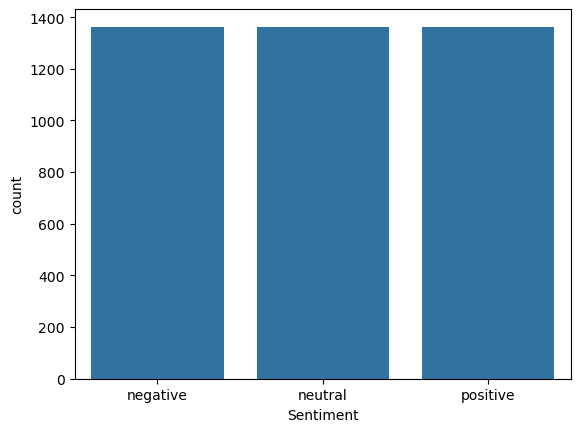

In [25]:
# Visualising train and test data distributions
sns.countplot(x="Sentiment", data=df_resampled)

<Axes: xlabel='Sentiment', ylabel='count'>

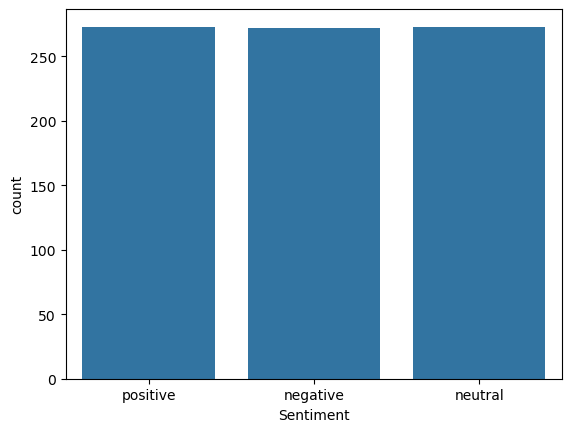

In [26]:
sns.countplot(x="Sentiment", data=df_test)

In [27]:
# 5.0 Preparing TF-IDF and Naive Bayes Model and data

X_train = df_resampled['Text']
y_train = df_resampled['Label']

X_val = df_val['Text']
y_val = df_val['Label']

X_test = df_test['Text']
y_test = df_test['Label']

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
 	('transformer', Pipeline([
 		('vect', CountVectorizer()),
 		('tfidf', TfidfTransformer())
 	])),
 	('clf', MultinomialNB())
])

pipeline.fit(X_train,y_train)

Pipeline(steps=[('transformer',
                 Pipeline(steps=[('vect', CountVectorizer()),
                                 ('tfidf', TfidfTransformer())])),
                ('clf', MultinomialNB())])

In [28]:
def labels(x):
  if x == 0:
    return 'neutral'
  elif x == 1:
    return 'negative'
  else:
    return 'positive'

df_test_NB = df_test.copy()
predictions = pipeline.predict(X_test)

df_test_NB['Sentiment_pred'] = predictions
df_test_NB['Sentiment_pred'] = df_test_NB['Sentiment_pred'].map(labels)

df_test_NB['pred_label'] = predictions

df_test_NB.head()

,Sentiment,Text,Tokens,Bi_grams,Tri_grams,Label,Sentiment_pred,pred_label
255,positive,operating profit totaled eur eur,"[operating, profit, totaled, eur, eur]","[operating_profit, profit_totaled, totaled_eur...","[operating_profit_totaled, profit_totaled_eur,...",2,negative,1
4077,negative,tietoenator pct extending recent lows last wee...,"[tietoenator, pct, extending, recent, lows, la...","[tietoenator_pct, pct_extending, extending_rec...","[tietoenator_pct_extending, pct_extending_rece...",1,negative,1
4063,negative,operating loss amounted eur compared profit eu...,"[operating, loss, amounted, eur, compared, pro...","[operating_loss, loss_amounted, amounted_eur, ...","[operating_loss_amounted, loss_amounted_eur, a...",1,negative,1
2904,neutral,finnish publisher alma media hel alnv said wed...,"[finnish, publisher, alma, media, hel, alnv, s...","[finnish_publisher, publisher_alma, alma_media...","[finnish_publisher_alma, publisher_alma_media,...",0,neutral,0
886,positive,tele affarsvarlden gave buy recommendation mob...,"[tele, affarsvarlden, gave, buy, recommendatio...","[tele_affarsvarlden, affarsvarlden_gave, gave_...","[tele_affarsvarlden_gave, affarsvarlden_gave_b...",2,positive,2


In [29]:
# 5.1 Performance Metrics for TF-IDF + Naive Bayes Model
print('Classification_report of TF-IDF And Naive Bayes Classifier:')
print(classification_report(df_test_NB['Sentiment'], df_test_NB['Sentiment_pred']))

Classification_report of TF-IDF And Naive Bayes Classifier:
              precision    recall  f1-score   support

    negative       0.80      1.00      0.89       272
     neutral       0.96      0.84      0.90       273
    positive       0.92      0.82      0.87       273

    accuracy                           0.89       818
   macro avg       0.90      0.89      0.88       818
weighted avg       0.90      0.89      0.88       818



In [30]:
# 5.2 Preparing BERT (Bidirectional Encoder Representation Transformer) using DistilBERT (pretrained)

bert_model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased",num_labels=3)
tokenizer = BertTokenizer.from_pretrained("distilbert-base-uncased")

You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'enc

In [36]:
# 5.3 Preparing data for BERT model
from datasets import Dataset
dataset_train = Dataset.from_pandas(df_resampled)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

# 5.4 Tokenize the datasets
def tokenize_function(examples):
    return tokenizer(examples['Text'], truncation=True, padding='max_length', max_length=128)

dataset_train = dataset_train.map(tokenize_function, batched=True)
dataset_val = dataset_val.map(tokenize_function, batched=True)
dataset_test = dataset_test.map(tokenize_function, batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'Label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'Label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'Label'])

Map:   0%|          | 0/4089 [00:00<?, ? examples/s]

Map:   0%|          | 0/328 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [37]:
# Metric evaluator for BERT Model
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(predictions, labels)}

# Obtains the Training Arguments 
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir='temp/',
    evaluation_strategy="steps",
    num_train_epochs=5,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs4',            
    # logging_steps=10,  # Uncomment if you want to specify how often to log
    load_best_model_at_end=True,
)

# Create the trainer for BERT Model
from transformers import Trainer

trainer = Trainer(
    model=bert_model,                         
    args=args,                  
    train_dataset=dataset_train,         
    eval_dataset=dataset_val,           
    compute_metrics=compute_metrics
)

# Start training
trainer.train()

  0%|          | 0/640 [00:00<?, ?it/s]

ValueError: The model did not return a loss from the inputs, only the following keys: logits. For reference, the inputs it received are input_ids,token_type_ids,attention_mask.

In [ ]:
from transformers import BertForSequenceClassification

# 5.2 Preparing BERT (Bidirectional Encoder Representation Transformer) using DistilBERT (pretrained)
bert_model = BertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)

# Metric evaluator for BERT Model
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy': accuracy_score(predictions, labels)}

# Ensuring the dataset format is correct
dataset_train = dataset_train.rename_column('Label', 'labels')
dataset_val = dataset_val.rename_column('Label', 'labels')
dataset_test = dataset_test.rename_column('Label', 'labels')

dataset_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'labels'])
dataset_val.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'labels'])
dataset_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'token_type_ids', 'labels'])

# Training arguments
from transformers import TrainingArguments

args = TrainingArguments(
    output_dir='temp/',
    evaluation_strategy="steps",
    num_train_epochs=5,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=64,   
    warmup_steps=500,                
    weight_decay=0.01,               
    logging_dir='./logs4',            
    load_best_model_at_end=True,
)

# Create the trainer for BERT Model
from transformers import Trainer

trainer = Trainer(
    model=bert_model,                         
    args=args,                  
    train_dataset=dataset_train,         
    eval_dataset=dataset_val,           
    compute_metrics=compute_metrics
)

# Start training
trainer.train()


You are using a model of type distilbert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'embeddings.LayerNorm.bias', 'embeddings.LayerNorm.weight', 'embeddings.position_embeddings.weight', 'embeddings.token_type_embeddings.weight', 'embeddings.word_embeddings.weight', 'encoder.layer.0.attention.output.LayerNorm.bias', 'encoder.layer.0.attention.output.LayerNorm.weight', 'encoder.layer.0.attention.output.dense.bias', 'encoder.layer.0.attention.output.dense.weight', 'encoder.layer.0.attention.self.key.bias', 'encoder.layer.0.attention.self.key.weight', 'encoder.layer.0.attention.self.query.bias', 'encoder.layer.0.attention.self.query.weight', 'encoder.layer.0.attention.self.value.bias', 'encoder.layer.0.attention.self.value.weight', 'enc

  0%|          | 0/640 [00:00<?, ?it/s]